In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jan 30 07:53:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
from datetime import datetime
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import sparse
from scipy.sparse import csc_matrix
from sklearn.decomposition import TruncatedSVD

np.random.seed(0)

### Setup and Load dataset

In [ ]:

import pandas as pd
import os
from os.path import exists
import zipfile
import numpy as np

In [ ]:
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

!pip uninstall scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install --upgrade --no-cache-dir gdown


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [ ]:
!gdown --id 15NcjFuDNMozx2kR8-OMFq5Y206xtzWEj


/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=15NcjFuDNMozx2kR8-OMFq5Y206xtzWEj
To: /content/100k_a.zip
100% 44.8M/44.8M [00:00<00:00, 100MB/s]


### Setup

In [ ]:

import pandas as pd
import os
from os.path import exists
import zipfile
import numpy as np

In [ ]:
!unzip -o "100k_a.zip"  -d  "/content"

Archive:  100k_a.zip
  inflating: /content/100k_a.csv     


In [ ]:
colnames=['userID','StreamID','Streamer_username','Time_start','Time_stop']
data_df = pd.read_csv("100k_a.csv",names=colnames)


In [ ]:
data_df.rename(columns = {'Streamer_username':'itemID'}, inplace = True)


In [ ]:
data_df['duration']=data_df['Time_stop']-data_df['Time_start']

In [ ]:
rating_df=data_df.groupby(['userID', 'itemID'])['duration'].sum().reset_index()


In [ ]:
rating_df.rename(columns = {'duration':'rating'}, inplace = True)


# Details about dataset

In [ ]:
summary_df=pd.DataFrame(columns=['Dataset','Algorithm','Sparsity','Precision@k'])

In [ ]:
userID="userID"
itemID="itemID"
score="rating"
timestamp='time'

# Sparsity 

In [ ]:
from scipy.sparse import csr_matrix
def checkSparsity(main_df):
   
    # pivot_df = main_df.pivot_table(
    #     index='itemID',
    #     columns='userID',
    #     values='rating'
    # )
    totalUsers=main_df.userID.unique().shape[0]
    totalitems= main_df.itemID.unique().shape[0]
    total=totalUsers*totalitems
    totalreconds=main_df.shape[0]
    sparsity=(total-totalreconds)/total
    return sparsity

In [ ]:

y = rating_df.groupby('userID').count()['rating']>=50
new = y[y].index
rating_df = rating_df[rating_df['userID'].isin(new)]
rating_df.shape
y = rating_df.groupby('itemID').count()['rating']>=50
new = y[y].index
rating_df = rating_df[rating_df['itemID'].isin(new)]

In [ ]:

sparsity=checkSparsity(rating_df)
sparsity

0.9658830406384222

In [ ]:
# movie_10k_df['rating']=1
# amazon_df['rating']=1
# book_df['rating']=1
# food_df['rating']=1
# ciao_df['rating']=1
# ecommerce_df['rating']=1

In [ ]:
import time
import datetime
def replaceCatagoricalValues(df,colstoskip):
    
    catagoricals_cols=df.select_dtypes(include=['object']).columns.tolist()
    
    for col in catagoricals_cols:
      if col in colstoskip:
        continue
      unique_items = df[col].unique()
      item_ids = dict(zip(unique_items, np.arange(unique_items.shape[0], dtype=np.int32)))
      dict_items = {}
      index = 0
      for ids in item_ids:
        dict_items[ids] = index
        index += 1
      df[col] = df[col].map(dict_items)

    return df

In [ ]:
rating_df=replaceCatagoricalValues(rating_df,['rating'])

In [ ]:
twitch_df=rating_df

In [ ]:
twitch_df.shape

(67120, 3)

# Factorization machine

In [ ]:
!pip install rankfm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from rankfm.rankfm import RankFM
from rankfm.evaluation import hit_rate, reciprocal_rank, discounted_cumulative_gain, precision, recall, diversity
from datetime import datetime


In [ ]:
EPOCHS=50
MAX_SAMPLES=30
ALPHA=0.01
SIGMA=0.1
LR=0.10
LOSS='warp'
FACTORS=20

In [ ]:
FMUSER='user_id'
FMITEM='item_id'

In [ ]:
class FactMachineExplicit:
  def setup(self,fm_df):
    self.valid_recommendations= None
    fm_df['random'] = np.random.random(size=len(fm_df))
    test_pct = 0.25
    train_mask = fm_df['random'] <  (1 - test_pct)
    valid_mask = fm_df['random'] >= (1 - test_pct)
    self.interactions_train = fm_df[train_mask].groupby([FMUSER, FMITEM]).mean().reset_index()
    self.interactions_valid = fm_df[valid_mask].groupby([FMUSER, FMITEM]).mean().reset_index()
 
   
    self.weight_train = np.log2(self.interactions_train[RATING] + 1)
    self.weight_valid =  np.log2(self.interactions_valid[RATING] + 1)

    self.interactions_train=self.interactions_train[[FMUSER, FMITEM]]
    self.interactions_valid=self.interactions_valid[[FMUSER, FMITEM]]
    self.train_users = np.sort(self.interactions_train[FMUSER].unique())
    self.valid_users = np.sort(self.interactions_valid[FMUSER].unique())
    cold_start_users = set(self.valid_users) - set(self.train_users)
    self.train_items = np.sort(self.interactions_train[FMITEM].unique())
    self.valid_items = np.sort(self.interactions_valid[FMITEM].unique())
    cold_start_items = set(self.valid_items) - set(self.train_items)
    
    print("train shape: {}".format(self.interactions_train.shape))
    print("valid shape: {}".format(self.interactions_valid.shape))

    print("train users: {}".format(len(self.train_users)))
    print("valid users: {}".format(len(self.valid_users)))
    print("cold-start users: {}".format(cold_start_users))

    print("train items: {}".format(len(self.train_items)))
    print("valid items: {}".format(len(self.valid_items)))
    print("cold-start items: {}".format(cold_start_items))
    self.user_features_train=None
    self.user_features_valid=None
    self.item_features_train=None
    self.item_features_valid=None

     
    self.model = RankFM(factors=FACTORS, loss=LOSS, max_samples=MAX_SAMPLES, alpha=ALPHA, sigma=SIGMA, learning_rate=LR, learning_schedule='invscaling')

  def train(self):
    #print(self.item_features_train.columns[0])
    before= datetime.now()
    # if self.item_features_train is not None and self.user_features_train is not None:
    #   self.model.fit(self.interactions_train,item_features=self.item_features_train,user_features=self.user_features_train, epochs=20, verbose=True)
    # if self.item_features_train is  None and self.user_features_train is not None:
    #   self.model.fit(self.interactions_train,user_features=self.user_features_train, epochs=EPOCHS, verbose=True)
 
    # if self.item_features_train is not None and self.user_features_train is  None:
    #   self.model.fit(self.interactions_train,sample_weight=self.weight_train,item_features=self.item_features_train, epochs=EPOCHS, verbose=True)
    # if self.item_features_train is  None and self.user_features_train is  None:
    self.model.fit(self.interactions_train,sample_weight=self.weight_train, epochs=EPOCHS, verbose=False)
 
    after= datetime.now()
    self.duration = after-before 
  def evaluate(self,k):
    if self.valid_recommendations is None:
      self.valid_recommendations = self.model.recommend(self.valid_users, n_items=10, filter_previous=True, cold_start='nan')
    self.model_hit_rate = hit_rate(self.model, self.interactions_valid, k=k)
    self.model_reciprocal_rank = reciprocal_rank(self.model, self.interactions_valid, k=k)
    self.model_dcg = discounted_cumulative_gain(self.model, self.interactions_valid, k=k)
    self.model_precision = precision(self.model, self.interactions_valid, k=k)
    self.model_recall = recall(self.model, self.interactions_valid, k=k)
    print("hit_rate: {:.3f}".format(self.model_hit_rate))
    print("reciprocal_rank: {:.3f}".format(self.model_reciprocal_rank))
    print("dcg: {:.3f}".format(self.model_dcg, 3))
    print("precision: {:.3f}".format(self.model_precision))
    print("recall: {:.3f}".format(self.model_recall))
    return self.model_recall,self.model_precision,self.model_hit_rate,self.duration.total_seconds()



In [ ]:
USER="userID"
ITEM="itemID"
RATING="rating"
TOP_K=10

In [ ]:
fm_df=twitch_df.copy()

FMUSER='user_id'
FMITEM='item_id'
fm_df.rename(columns = {USER:FMUSER, ITEM:FMITEM}, inplace = True)
fm_df=fm_df[[FMUSER,FMITEM,RATING]]
fm=FactMachineExplicit()
fm.setup(fm_df)
fm.train()
fm_testrecall,fm_testprecesion,hit,fm_duration=fm.evaluate(TOP_K)


train shape: (50226, 2)
valid shape: (16894, 2)
train users: 3546
valid users: 3245
cold-start users: {50819, 43780, 3590, 10633, 4490, 7960, 88987, 26910, 79006, 49570, 38436, 27942, 94246, 6695, 75435, 96429, 66991, 72242, 25523, 54067, 62649, 14844, 10436, 1362, 45652, 13919, 28260, 53988, 23914, 62574, 69500}
train items: 550
valid items: 550
cold-start items: set()
hit_rate: 0.558
reciprocal_rank: 0.161
dcg: 0.330
precision: 0.079
recall: 0.197


In [ ]:
df2 = {'Dataset':"Twitch",'Algorithm':"Factorization Machine",'Sparsity':sparsity,'Recall@K':fm_testrecall,'Precision@k':fm_testprecesion,'HitRate@k':hit}
summary_df = summary_df.append(df2, ignore_index = True)

In [ ]:
summary_df

,Dataset,Algorithm,Sparsity,Precision@k,HitRate@k,Recall@K
0,Twitch,Factorization Machine,0.965883,0.079091,0.558183,0.197351


# RBM

In [ ]:
!pip install recommenders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 339.0/339.0 KB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 KB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.1/310.1 KB 35.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 108.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.4/662.4 KB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.2/355.2 KB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 80.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 65.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.5/402.5 KB 46.9 MB/s eta 0:00:00
     ━━━━━━

In [ ]:

from recommenders.datasets.python_splitters import python_random_split,  python_stratified_split

from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.models.cornac.cornac_utils import predict_ranking
from recommenders.utils.timer import Timer
from recommenders.utils.constants import SEED


In [ ]:
import torch
import cornac

In [ ]:

from recommenders.models.rbm.rbm import RBM
from recommenders.datasets.python_splitters import numpy_stratified_split
from recommenders.datasets.sparse import AffinityMatrix
from recommenders.datasets import movielens
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.utils.timer import Timer
from recommenders.utils.plot import line_graph

In [ ]:
rating_df=twitch_df.copy()


In [ ]:
item_ids = list(set(list(rating_df.itemID.unique())))
user_ids = list(set(list(rating_df.userID.unique())))

In [ ]:
dict_users = {}
index = 0
for ids in sorted(user_ids):
    dict_users[ids] = index
    index += 1
dict_items = {}
index = 0
for ids in sorted(item_ids):
    dict_items[ids] = index
    index += 1

In [ ]:
rating_df['userID'] = rating_df.userID.map(dict_users)
rating_df['itemID'] = rating_df.itemID.map(dict_items)

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# rating_df[['rating']] = scaler.fit_transform(rating_df[['rating']])

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


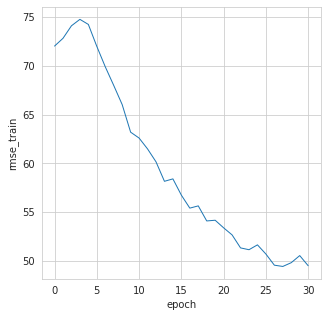

In [ ]:
header = {
        "col_user": "userID",
        "col_item": "itemID",
        "col_rating": "rating",
    }

#instantiate the sparse matrix generation  
am = AffinityMatrix(df =rating_df, **header)

#obtain the sparse matrix 
X, _, _ = am.gen_affinity_matrix()
Xtr, Xtst = numpy_stratified_split(X)
#First we initialize the model class
model = RBM(
    possible_ratings=np.setdiff1d(np.unique(Xtr), np.array([0])),
    visible_units=Xtr.shape[1],
    hidden_units=600,
    training_epoch=30,
    minibatch_size=60,
    keep_prob=0.8,
    with_metrics=True
)
# Model Fit
model.fit(Xtr)

# Plot the train RMSE as a function of the epochs
line_graph(values=model.rmse_train, labels='train', x_name='epoch', y_name='rmse_train')


In [ ]:
top_k =  model.recommend_k_items(Xtst)
top_k_df = am.map_back_sparse(top_k, kind = 'prediction')
test_df = am.map_back_sparse(Xtst, kind = 'ratings')

In [ ]:
eval_precision = precision_at_k(test_df, top_k_df, col_user="userID", col_item="itemID", 
                               col_rating="rating", col_prediction="prediction", 
                               relevancy_method="top_k", k= 20)

In [ ]:
eval_recall = recall_at_k(test_df, top_k_df, col_user="userID", col_item="itemID", 
                          col_rating="rating", col_prediction="prediction", 
                          relevancy_method="top_k", k= 20)


In [ ]:
eval_precision

0.07778771615980919

In [ ]:
df2 = {'Dataset':"twitch",'Algorithm':"RBM",'Sparsity':sparsity,'Precision@k':eval_precision,'Recall@k':eval_recall}
summary_df = summary_df.append(df2, ignore_index = True)

In [ ]:
summary_df

,Dataset,Algorithm,Sparsity,Precision@k,HitRate@k,Recall@K,Recall@k
0,Twitch,Factorization Machine,0.965883,0.079091,0.558183,0.197351,NaN
1,twitch,RBM,0.965883,0.077788,NaN,NaN,0.330636


#BPR

In [ ]:
import cornac
from recommenders.datasets.python_splitters import python_random_split,python_stratified_split
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.models.cornac.cornac_utils import predict_ranking
from recommenders.utils.timer import Timer
from recommenders.utils.constants import SEED



In [ ]:
df=twitch_df.copy()
df=df[['userID','itemID','rating']]
train, test = python_stratified_split(df, 0.75)

train_set = cornac.data.Dataset.from_uir(train.itertuples(index=False), seed=SEED)
bpr = cornac.models.BPR(
    k=200,
    max_iter=100,
    learning_rate=0.01,
    lambda_reg=0.001,
    verbose=True,
    seed=42
)

bpr.fit(train_set)

all_predictions = predict_ranking(bpr, train, usercol='userID', itemcol='itemID', remove_seen=True)

k = 10
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=k)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=k)

print(
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Precision@K:	0.174270
Recall@K:	0.350382


In [ ]:

df2 = {'Dataset':"twitch",'Algorithm':"BPR",'Sparsity':sparsity,'Recall@K':eval_recall,'Precision@k': eval_precision }
summary_df = summary_df.append(df2, ignore_index = True)
summary_df

,Dataset,Algorithm,Sparsity,Precision@k,HitRate@k,Recall@K,Recall@k
0,Twitch,Factorization Machine,0.965883,0.079091,0.558183,0.197351,NaN
1,twitch,RBM,0.965883,0.077788,NaN,NaN,0.330636
2,twitch,BPR,0.965883,0.174270,NaN,0.350382,NaN


# LightGCN

In [ ]:
!pip install recommenders

In [ ]:
from recommenders.utils.timer import Timer
from recommenders.models.deeprec.models.graphrec.lightgcn import LightGCN
from recommenders.models.deeprec.DataModel.ImplicitCF import ImplicitCF
from recommenders.datasets import movielens
from recommenders.datasets.python_splitters import python_stratified_split
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.utils.constants import SEED as DEFAULT_SEED
from recommenders.models.deeprec.deeprec_utils import prepare_hparams

In [ ]:
from datetime import datetime


In [ ]:
SEED=0
# top k items to recommend
TOP_K = 10

# Model parameters
EPOCHS = 20
BATCH_SIZE = 256

In [ ]:
def runLighGCN(df_input):
  gcn_df=df_input.copy()
  ct = datetime.now()

  
  gcn_df=gcn_df[['userID','itemID','rating']]
  gcn_item_ids = list(set(list(gcn_df.itemID.unique())))
  gcn_user_ids = list(set(list(gcn_df.userID.unique())))
  dict_items = {}
  index = 0
  for ids in sorted(gcn_item_ids):
      dict_items[ids] = index
      index += 1
  dict_users = {}
  index = 0
  for ids in sorted(gcn_user_ids):
      dict_users[ids] = index
      index += 1
  gcn_df["itemID"] = gcn_df["itemID"].map(dict_items)
  gcn_df["userID"] = gcn_df["userID"].map(dict_users)
  gcn_df.reset_index()
  train, test = python_stratified_split(gcn_df, ratio=0.8)
  data = ImplicitCF(train=train, test=test, seed=SEED)
  yaml_file = "param_gcn.yaml"
  hparams = prepare_hparams(yaml_file,
                            n_layers=4,
                            batch_size=BATCH_SIZE,
                            epochs=EPOCHS,
                            learning_rate=0.005,
                            eval_epoch=5,
                            top_k=TOP_K,
                           )
  model = LightGCN(hparams, data, seed=SEED)
  before= datetime.now()
  model.fit()
  after= datetime.now()
  duration=after-before
  topk_scores = model.recommend_k_items(test, top_k=TOP_K, remove_seen=True)
  eval_map = map_at_k(test, topk_scores, k=TOP_K)
  eval_ndcg = ndcg_at_k(test, topk_scores, k=TOP_K)
  eval_precision = precision_at_k(test, topk_scores, k=TOP_K)
  eval_recall = recall_at_k(test, topk_scores, k=TOP_K)
  # Record results with papermill for tests
  print("map"+ str(eval_map))
  print("ndcg"+ str(eval_ndcg))
  print("precision"+ str( eval_precision))
  print("recall"+ str(eval_recall))
  return eval_map,eval_ndcg,eval_precision,eval_recall,duration.total_seconds()

In [ ]:
df=twitch_df.copy()
gcn_eval_map,gcn_eval_ndcg,gcn_eval_precision,gcn_eval_recall,gcn_duration=None,None,None,None,None

gcn_eval_map,gcn_eval_ndcg,gcn_eval_precision,gcn_eval_recall,gcn_duration=runLighGCN(df)



Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.
Epoch 1 (train)0.9s: train loss = 0.49553 = (mf)0.49518 + (embed)0.00035
Epoch 2 (train)0.8s: train loss = 0.28711 = (mf)0.28598 + (embed)0.00114
Epoch 3 (train)0.9s: train loss = 0.22343 = (mf)0.22173 + (embed)0.00170
Epoch 4 (train)0.8s: train loss = 0.19370 = (mf)0.19156 + (embed)0.00213
Epoch 5 (train)0.8s + (eval)0.3s: train loss = 0.17293 = (mf)0.17042 + (embed)0.00250, recall = 0.38633, ndcg = 0.31065, precision = 0.13980, map = 0.20269
Epoch 6 (train)0.7s: train loss = 0.15636 = (mf)0.15353 + (embed)0.00283
Epoch 7 (train)0.7s: train loss = 0.14686 = (mf)0.14374 + (embed)0.00312
Epoch 8 (train)0.7s: train loss = 0.13736 = (mf)0.13397 + (embed)0.00339
Epoch 9 (train)0.7s: train loss = 0.12727 = (mf)0.12362 + (embed)0.00365
Epoch 10 (train)0.7s + (eval)0.2s: train loss = 0.12119 = (mf)0.11732 + (embed)0.00388, recall = 0.41700, ndcg = 0.33594, precision = 0.14982, map = 0.22196
map0.

In [ ]:
df2 = {'Dataset':"twitch",'Algorithm':"LightGCN",'Sparsity':sparsity,'Precision@k':gcn_eval_precision,'Recall@k':gcn_eval_recall}
summary_df = summary_df.append(df2, ignore_index = True)

In [ ]:
summary_df

,Dataset,Algorithm,Sparsity,Precision@k,HitRate@k,Recall@K,Recall@k,rmse
0,Twitch,Factorization Machine,0.965883,0.079091,0.558183,0.197351,NaN,NaN
1,twitch,RBM,0.965883,0.077788,NaN,NaN,0.330636,NaN
2,twitch,BPR,0.965883,0.174270,NaN,0.350382,NaN,NaN
3,twitch,NCF,0.965883,0.161538,NaN,NaN,0.332979,NaN
4,twitch,BiVAE,0.965883,0.158388,NaN,NaN,0.296624,NaN
5,twitch,SVD,0.965883,0.023049,0.351067,NaN,NaN,14.240035
6,twitch,NMF,0.965883,0.016215,0.270980,NaN,NaN,13.814859
7,twitch,LightGCN,0.965883,0.149821,NaN,NaN,0.416999,NaN


# BiVAE

In [ ]:

from recommenders.datasets.python_splitters import python_random_split,  python_stratified_split

from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.models.cornac.cornac_utils import predict_ranking
from recommenders.utils.timer import Timer
from recommenders.utils.constants import SEED


In [ ]:
import torch
import cornac

In [ ]:
import pandas as pd
from recommenders.datasets import movielens
from recommenders.datasets.python_splitters import python_random_split
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.models.cornac.cornac_utils import predict_ranking
from recommenders.utils.timer import Timer
from recommenders.utils.constants import SEED

In [ ]:
TOP_K = 10

# Model parameters
LATENT_DIM = 50
ENCODER_DIMS = [100]
ACT_FUNC = "tanh"
LIKELIHOOD = "pois"
NUM_EPOCHS = 50
BATCH_SIZE = 512
LEARNING_RATE = 0.001

In [ ]:
rating_df=twitch_df.copy()
rating_df['rating']=1

In [ ]:
item_ids = list(set(list(rating_df.itemID.unique())))
user_ids = list(set(list(rating_df.userID.unique())))
dict_users = {}
index = 0
for ids in sorted(user_ids):
    dict_users[ids] = index
    index += 1
dict_items = {}
index = 0
for ids in sorted(item_ids):
    dict_items[ids] = index
    index += 1
rating_df['userID'] = rating_df.userID.map(dict_users)
rating_df['itemID'] = rating_df.itemID.map(dict_items)
train, test = python_random_split(rating_df, 0.75)
train_set = cornac.data.Dataset.from_uir(train.itertuples(index=False), seed=SEED)

#First we initialize the model class
model = bivae = cornac.models.BiVAECF(
    k=LATENT_DIM,
    encoder_structure=ENCODER_DIMS,
    act_fn=ACT_FUNC,
    likelihood=LIKELIHOOD,
    n_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    seed=SEED,
    use_gpu=torch.cuda.is_available(),
    verbose=True
)
# Model Fit
model.fit(train_set)

all_predictions = predict_ranking(bivae, train, usercol='userID', itemcol='itemID', remove_seen=True)
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)

print(
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')


  0%|          | 0/50 [00:00<?, ?it/s]

Precision@K:	0.158388
Recall@K:	0.296624


In [ ]:
df2 = {'Dataset':"twitch",'Algorithm':"BiVAE",'Sparsity':sparsity,'Precision@k':eval_precision,'Recall@k':eval_recall}
summary_df = summary_df.append(df2, ignore_index = True)

In [ ]:
summary_df

,Dataset,Algorithm,Sparsity,Precision@k,HitRate@k,Recall@K,Recall@k
0,Twitch,Factorization Machine,0.965883,0.079091,0.558183,0.197351,NaN
1,twitch,RBM,0.965883,0.077788,NaN,NaN,0.330636
2,twitch,BPR,0.965883,0.174270,NaN,0.350382,NaN
3,twitch,NCF,0.965883,0.161538,NaN,NaN,0.332979
4,twitch,BiVAE,0.965883,0.158388,NaN,NaN,0.296624


# Compare Results

In [ ]:
summary_df[['Dataset','Algorithm','Precision@k']].sort_values(by=['Dataset','Precision@k'],ascending=False)

,Dataset,Algorithm,Precision@k
2,twitch,BPR,0.174270
3,twitch,NCF,0.161538
1,twitch,RBM,0.077788
0,Twitch,Factorization Machine,0.079091


# NCF

In [ ]:
!pip install tf_slim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 26.3 MB/s eta 0:00:00


### twitch

In [ ]:
import pandas as pd
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.utils.timer import Timer
from recommenders.models.ncf.ncf_singlenode import NCF
from recommenders.models.ncf.dataset import Dataset as NCFDataset
from recommenders.datasets import movielens
from recommenders.utils.notebook_utils import is_jupyter
from recommenders.datasets.python_splitters import python_chrono_split
from recommenders.evaluation.python_evaluation import (rmse, mae, rsquared, exp_var, map_at_k, ndcg_at_k, precision_at_k, 
                                                     recall_at_k, get_top_k_items)

In [ ]:
df=twitch_df.copy()
train, test = python_stratified_split(df, 0.75)

In [ ]:
SEED=0
# top k items to recommend
TOP_K = 10

# Model parameters
EPOCHS = 10
BATCH_SIZE = 256


In [ ]:
test = test[test["userID"].isin(train["userID"].unique())]
test = test[test["itemID"].isin(train["itemID"].unique())]
train_file = "./train.csv"
test_file = "./test.csv"
train.to_csv(train_file, index=False)
test.to_csv(test_file, index=False)
data = NCFDataset(train_file=train_file, test_file=test_file, seed=SEED)
model = NCF (
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=4,
    layer_sizes=[16,8,4],
    n_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=1e-3,
    verbose=10,
    seed=SEED
)
model.fit(data)

100%|██████████| 3354/3354 [00:42<00:00, 79.39it/s]
/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [ ]:
with Timer() as test_time:
    users, items, preds = [], [], []
    item = list(train.itemID.unique())
    for user in train.userID.unique():
        user = [user] * len(item) 
        users.extend(user)
        items.extend(item)
        preds.extend(list(model.predict(user, item, is_list=True)))

    all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

    merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
    all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

print("Took {} seconds for prediction.".format(test_time))

Took 6.8728 seconds for prediction.


In [ ]:
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)

print(
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

Precision@K:	0.161538
Recall@K:	0.332979


In [ ]:
df2 = {'Dataset':"twitch",'Algorithm':"NCF",'Sparsity':sparsity,'Precision@k':eval_precision,'Recall@k':eval_recall}
summary_df = summary_df.append(df2, ignore_index = True)

In [ ]:
summary_df[['Dataset','Algorithm','Precision@k']].sort_values(by=['Dataset','Precision@k'],ascending=False)

,Dataset,Algorithm,Precision@k
2,twitch,BPR,0.174270
3,twitch,NCF,0.161538
1,twitch,RBM,0.077788
0,Twitch,Factorization Machine,0.079091


# Matrix factorisation Methods

### Code Block

In [ ]:
from surprise import AlgoBase
from surprise import PredictionImpossible
import math
import numpy as np
import heapq
from datetime import datetime
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from datetime import datetime
from sklearn import preprocessing

In [ ]:
from surprise import accuracy
from collections import defaultdict
from surprise import Dataset,Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection.split import train_test_split



def surprisePreprocessing(rating_df,user_col="userID",item_col="itemID",rating_col="rating"):
  reader = Reader(rating_scale=(0, 5))
  data = Dataset.load_from_df(rating_df[[user_col, item_col, rating_col]], reader)
  trainset, testset = train_test_split(data, test_size=0.2)
  fullTrainSet = data.build_full_trainset()
  return trainset, testset,fullTrainSet
def Get_Top_Predictions_In_Actual_DataSet(predictions, n=20, minimumRating=0):
  topN = defaultdict(list)
  for uid, mid, actualRating in predictions:
      if (actualRating >= minimumRating):
          topN[uid].append((mid, actualRating))
  for uid, ratings in topN.items():
      ratings.sort(key=lambda x: x[1], reverse=True)
      topN[uid] = ratings[:n]
  return topN
def Get_Top_Predictions(predictions, n=10, minimumRating=3.0):
    topN = defaultdict(list)
    for uid, mid, actualRating, estimatedRating, _ in predictions:
        if (estimatedRating >= minimumRating):
            topN[uid].append((mid, estimatedRating))
    for uid, ratings in topN.items():
        ratings.sort(key=lambda x: x[1], reverse=True)
        topN[uid] = ratings[:n]
    return topN

In [ ]:
def MAE(predictions):
    return accuracy.mae(predictions, verbose=False)
def RMSE(predictions):
    return accuracy.rmse(predictions, verbose=False)

In [ ]:

class  MatrixFactorization:
  def __init__(self, algo):
    self.algo = algo
  
  def start(self,trainset,testset, n=20, verbose=True):
        before=datetime.now() 
        #trainSet, testSet = train_test_split(data, test_size=.25, random_state=1)
        self.algo.fit(trainset)
        after= datetime.now()
        duration = after-before                         
        self.duration = round(duration.total_seconds())
        print('time taken '+str(duration)+'s')
        predictions = self.algo.test(testset)
        self.rmse= RMSE(predictions)
        self.mae= MAE(predictions)
        print("Computing RMSE "+str(self.rmse))
        print("Computing MAE "+str(self.mae))
        return self.duration,self.rmse,self.mae
    
   
  def getModel(self):
        return self.algo
        
   
  def RecommendationMetricsOnwholeTestSet(self,trainset,testset,n=20):
       
        print("Computing recommendations with train and test dataset...")
        # Build predictions for all ratings  in the test set
        print("Predict ratings...")
        #allPredictions = self.algo.test(testset)
        bigTestSet = trainset.build_anti_testset()
        allPredictions = self.algo.test(bigTestSet)
        self.allPredictions=allPredictions
        # Compute top TOP_K recs for each user
        print("Compute top "+str(n)+ " recs per user")
        topNPredicted = Get_Top_Predictions(self.allPredictions, n)
        topNPredictedOnActualDataSet = Get_Top_Predictions_In_Actual_DataSet(testset, n=10)
        #Calculate hit rate
        self.Precision=self.Precision_k(topNPredicted, topNPredictedOnActualDataSet)
        self.hit=self.hitrate_k(topNPredicted, topNPredictedOnActualDataSet)
        print("\nPrecision@k: ",self.Precision )
        print("\nHit Rate@k: ",self.hit )
          
        return self.Precision,self.hit
  def Precision_k(self,topNPredicted, topNPredictedOnActualDataSet):
    totalhit_ratio=0;
    totalcount=0
    for userid in topNPredictedOnActualDataSet:
        totalcount+=1
        hit=0
        total=0
        predictions=[]
        actual_predictions=[]
        for item,_ in topNPredicted[int(userid)]:
            predictions.append(item)
        for item,_ in topNPredictedOnActualDataSet[int(userid)]:
            actual_predictions.append(item)
            
        for i in predictions:
            total+=1
            if i in actual_predictions:
                hit+=1
        if(total!=0):    
          totalhit_ratio+=(hit/total)
      

    self.Precision_k=(totalhit_ratio/totalcount)   
    return self.Precision_k
  def hitrate_k(self,topNPredicted, topNPredictedOnActualDataSet):
    totalhit_ratio=0;
    totalcount=0
    hit=0
    for userid in topNPredictedOnActualDataSet:
        totalcount+=1
       
        predictions=[]
        actual_predictions=[]
        for item,_ in topNPredicted[int(userid)]:
            predictions.append(item)
        for item,_ in topNPredictedOnActualDataSet[int(userid)]:
            actual_predictions.append(item)
            
        for i in predictions:
            if i in actual_predictions:
                hit+=1
                break
        

    self.hitrate_k=(hit/totalcount)   
    return self.hitrate_k

Run all Matrix factorization models on small sub sample

In [ ]:
def startMatrixFactorizationontwitch(bestmodel):

  ## Run best Model on whole dataset
  # final_matrix_fact_algo=None
  # bestmodel=runMatrixFactorizationOnSampleDataset()
  final_matrix_fact_algo=None
  if bestmodel=='SVD':
    final_matrix_fact_algo=SVD()
  if bestmodel=='SVDPP':
    final_matrix_fact_algo=SVDpp()
  if bestmodel=='NMF':
    final_matrix_fact_algo=NMF()
  trainset, testset,fullTrainSet=surprisePreprocessing(twitch_df)
  algo_surprise=MatrixFactorization(final_matrix_fact_algo)
  MF_duration,MF_rmse,MF_mae=algo_surprise.start(trainset,testset)
  MF__Precision_k,mf_hit=algo_surprise.RecommendationMetricsOnwholeTestSet(trainset,testset)

  return bestmodel,algo_surprise.algo,MF_rmse,MF_duration,MF__Precision_k,mf_hit

In [ ]:
df=twitch_df.copy()
product_ids = list(set(list(df.itemID.unique())))
user_ids = list(set(list(df.userID.unique())))
dict_products = {}
index = 0
for ids in sorted(product_ids):
    dict_products[ids] = index
    index += 1
dict_products = {}
index = 0
for ids in sorted(product_ids):
    dict_products[ids] = index
    index += 1
dict_users = {}
index = 0
for ids in sorted(user_ids):
    dict_users[ids] = index
    index += 1
df["itemID"] = df["itemID"].map(dict_products)
df["userID"] = df["userID"].map(dict_users)

amazon_int_df=df.copy()

## Experiment on movielens dataset

In [ ]:
bestmodel,algo_mf,MF_rmsemovielens,MF_durationmovielens,MF__Precision_kmovielens,mf_hitmovielens=startMatrixFactorizationontwitch('SVD')

  

time taken 0:00:00.618412s
Computing RMSE 14.240035304826934
Computing MAE 6.571662693682956
Computing recommendations with train and test dataset...
Predict ratings...
Compute top 20 recs per user

Precision@k:  0.02304874163746377

Hit Rate@k:  0.3510672188595094


In [ ]:
df2 = {'Dataset':"twitch",'Algorithm':"SVD",'Sparsity':sparsity,'rmse':MF_rmsemovielens,'Precision@k':MF__Precision_kmovielens,'HitRate@k':mf_hitmovielens}
summary_df = summary_df.append(df2, ignore_index = True)

In [ ]:
bestmodel,algo_mf,MF_rmsemovielens,MF_durationmovielens,MF__Precision_kmovielens,mf_hitmovielens=startMatrixFactorizationontwitch('NMF')

  

time taken 0:00:01.099118s
Computing RMSE 13.814858579494057
Computing MAE 6.091012644628762
Computing recommendations with train and test dataset...
Predict ratings...
Compute top 20 recs per user

Precision@k:  0.016215265903387385

Hit Rate@k:  0.2709801409352979


In [ ]:
df2 = {'Dataset':"twitch",'Algorithm':"NMF",'Sparsity':sparsity,'rmse':MF_rmsemovielens,'Precision@k':MF__Precision_kmovielens,'HitRate@k':mf_hitmovielens}
summary_df = summary_df.append(df2, ignore_index = True)

# Summary

In [ ]:
summary_df[['Dataset','Algorithm','Precision@k']].sort_values(by=['Dataset','Precision@k'],ascending=False)

,Dataset,Algorithm,Precision@k
2,twitch,BPR,0.174270
3,twitch,NCF,0.161538
4,twitch,BiVAE,0.158388
7,twitch,LightGCN,0.149821
1,twitch,RBM,0.077788
5,twitch,SVD,0.023049
6,twitch,NMF,0.016215
0,Twitch,Factorization Machine,0.079091
